<a href="https://colab.research.google.com/github/ArielFerreiro/ar-stamp-checker/blob/main/attempt.02/02_BBoxDetectionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the resized BBoxes (224x224 images) we create a model to train it to detect the stamp in a picture.

In [1]:
%load_ext autoreload
%autoreload 2

#### Load the drive to grab the images and labels

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Notebook Imports

In [34]:
import pickle
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.applications.vgg19 import VGG19
from sklearn.model_selection import train_test_split

#### Global Params

In [29]:
images_path = 'drive/My Drive/Colab Notebooks/stamps/original/'
results_path = 'drive/My Drive/Colab Notebooks/stamps/results/'
models_path = 'drive/My Drive/Colab Notebooks/stamps/models/'

#### Start

In [5]:
with open(results_path+"bboxes_224.pkl","rb") as f:
    (stamps, bboxes) = pickle.load(f)

In [6]:
stamps.shape

(1888, 224, 224, 3)

In [7]:
bboxes.shape

(1888, 10)

In [8]:
# retain only the bounding boxes numbers (x,y,delta_x,delta_y)
bboxes = bboxes[:,1:5]
bboxes.shape

(1888, 4)

In [9]:
bboxes[bboxes == ''] = 0.0
bboxes = bboxes.astype(np.float)

In [10]:
bboxes.max()

193.0

In [11]:
stamps.max()

255

In [12]:
# Normalize the datasets
bboxes = bboxes / bboxes.max()
stamps = stamps / stamps.max()

In [13]:
# datasets creation
X_train, X_test, y_train, y_test = train_test_split(stamps, bboxes, random_state=5, test_size=0.1)

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1699, 224, 224, 3), (189, 224, 224, 3), (1699, 4), (189, 4))

#### Model

In [15]:
model = VGG19(include_top=False, input_shape=(224, 224, 3))

In [16]:
# no training on first CNN layers
for layer in model.layers:
    layer.trainable = False

In [17]:
model.get_layer(name="block5_pool").output

<tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 7, 7, 512) dtype=float32>

In [18]:
output = keras.layers.Flatten()(model.get_layer(name="block5_pool").output)
output = keras.layers.Dense(255)(output)
output = keras.layers.Activation("relu")(output)
output = keras.layers.Dense(4, activation="sigmoid")(output)

In [19]:
full_model = keras.models.Model(inputs=model.inputs, outputs=output)
full_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [20]:
# Callbacks
checkpoint_file='checkpoint.pmi-cnn-vgg19.h5'
checkpointer = keras.callbacks.ModelCheckpoint(checkpoint_file, 
                                               monitor="val_mse", 
                                               verbose=1, 
                                               save_best_only=True,
                                               mode='min')

In [21]:
full_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mse"])

In [22]:
history = full_model.fit(X_train, y_train, 
           epochs=20, batch_size=12, 
           validation_data=(X_test, y_test), callbacks=[checkpointer])

Epoch 1/20
142/142 [==============================] - ETA: 0s - loss: 0.7230 - mse: 0.0156
Epoch 00001: val_mse improved from inf to 0.00279, saving model to checkpoint.pmi-cnn-vgg19.h5
142/142 [==============================] - 13s 94ms/step - loss: 0.7230 - mse: 0.0156 - val_loss: 0.6325 - val_mse: 0.0028
Epoch 2/20
142/142 [==============================] - ETA: 0s - loss: 0.6311 - mse: 0.0025
Epoch 00002: val_mse improved from 0.00279 to 0.00212, saving model to checkpoint.pmi-cnn-vgg19.h5
142/142 [==============================] - 12s 87ms/step - loss: 0.6311 - mse: 0.0025 - val_loss: 0.6310 - val_mse: 0.0021
Epoch 3/20
142/142 [==============================] - ETA: 0s - loss: 0.6308 - mse: 0.0024
Epoch 00003: val_mse did not improve from 0.00212
142/142 [==============================] - 13s 89ms/step - loss: 0.6308 - mse: 0.0024 - val_loss: 0.6338 - val_mse: 0.0033
Epoch 4/20
142/142 [==============================] - ETA: 0s - loss: 0.6308 - mse: 0.0024
Epoch 00004: val_mse di

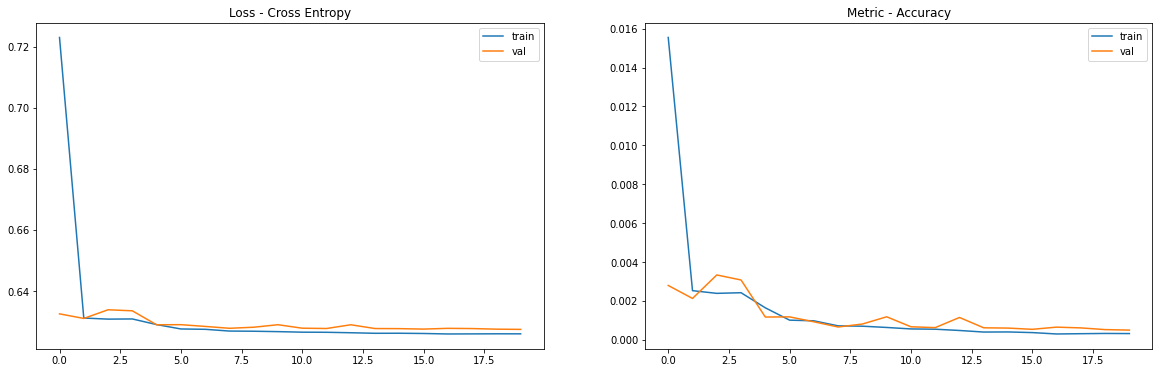

In [25]:
# Check results
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='val')
ax1.set_title('Loss - Cross Entropy')
ax1.legend()
ax2.plot(history.history['mse'], label='train')
ax2.plot(history.history['val_mse'], label='val')
ax2.set_title('Metric - MSE')
ax2.legend()
plt.show()

In [27]:
full_model.load_weights(checkpoint_file)
full_model.evaluate(stamps, bboxes)

59/59 [==============================] - 10s 162ms/step - loss: 0.6260 - mse: 2.7495e-04


[0.6259737014770508, 0.00027494641835801303]

#### Test

In [38]:
def check_predict(path, max_bbox=193):
  i = cv2.imread(path)
  i = cv2.resize(i, dsize=(224, 224))
  i = np.expand_dims(i, axis=0)
  i = i/i.max()
  prediccion = full_model.predict(i)
  bbox = prediccion[0]*max_bbox
  x, y, w, h = bbox
  crop = i[:, int(y):int(y+h), int(x):int(x+w), :]
  fig, ax = plt.subplots(1, 2, figsize=(15, 15))
  ax[0].imshow(i[0])
  ax[0].set_title("Given Image")
  ax[1].imshow(crop[0])
  ax[1].set_title("Estimated Box")
  plt.show()

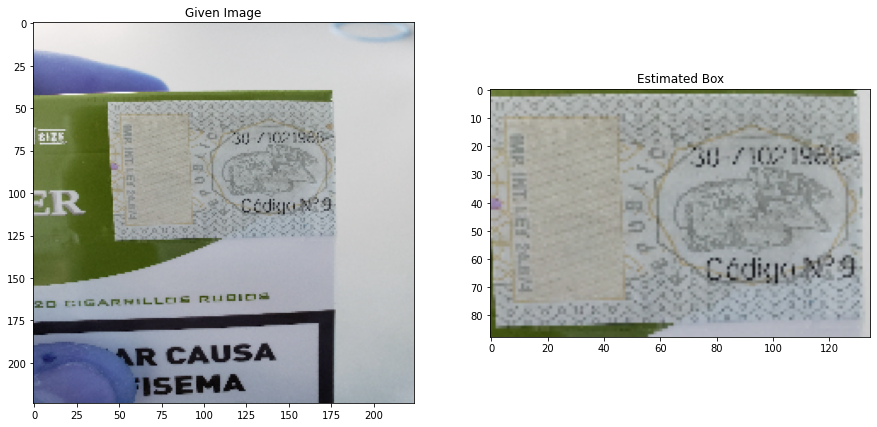

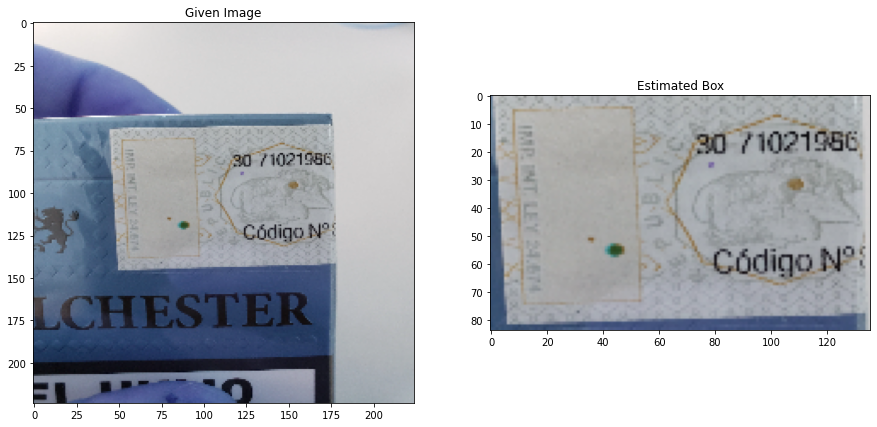

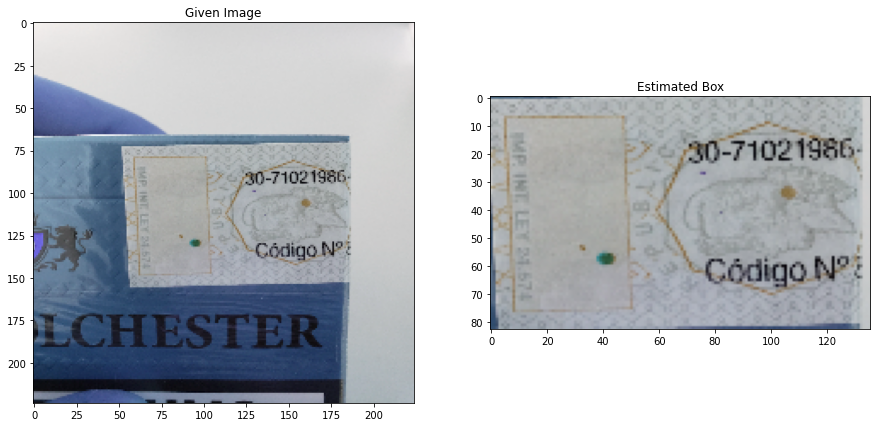

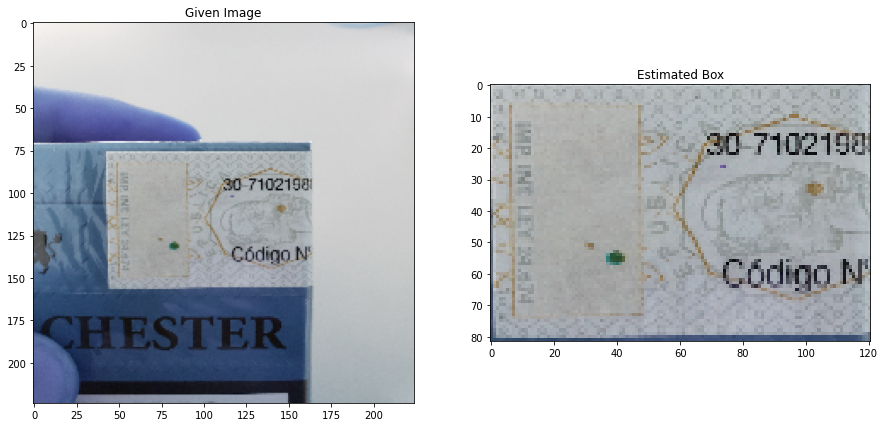

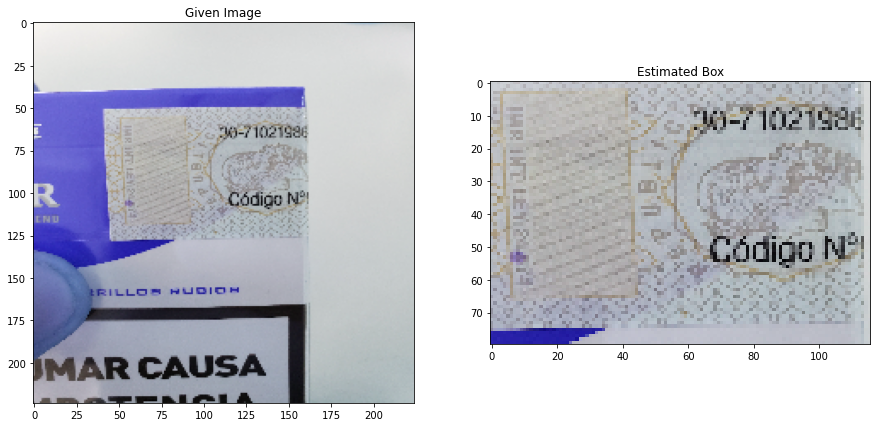

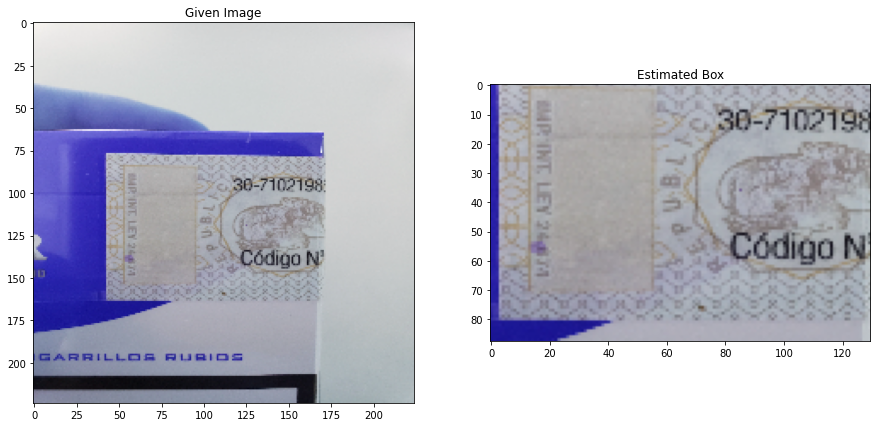

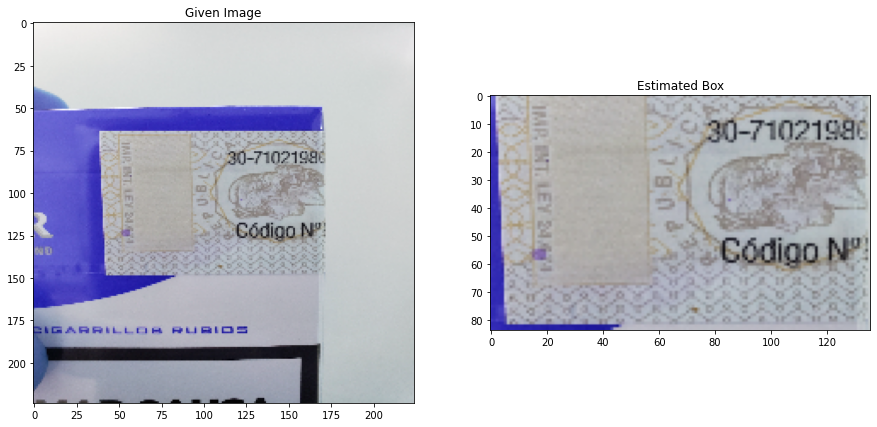

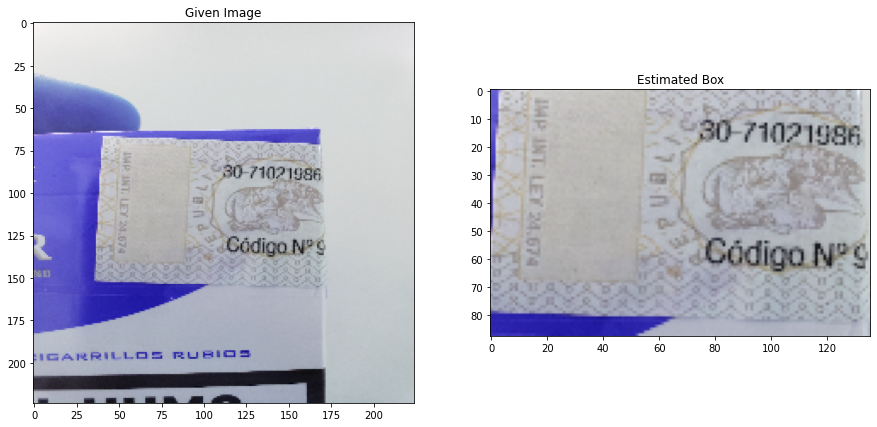

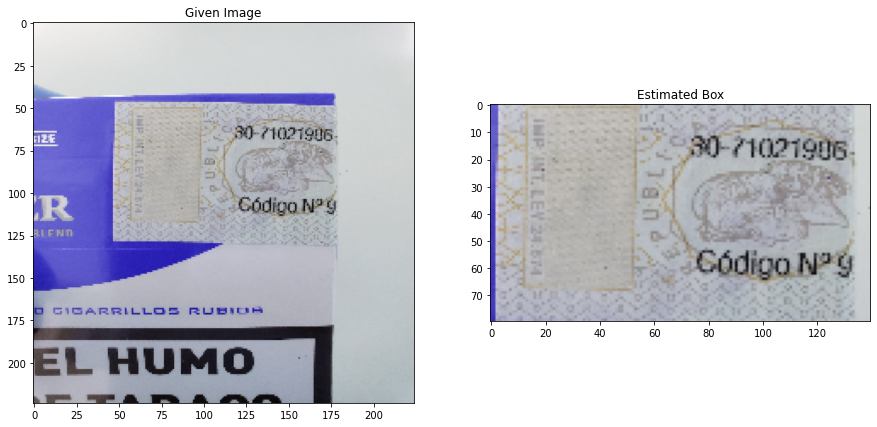

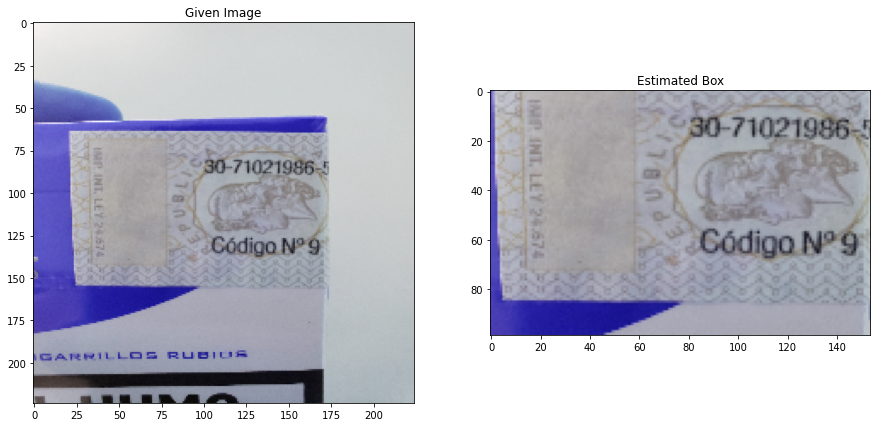

In [39]:
path_img = images_path + 'cft_box/'
for x in range(10):
  check_predict(path_img+os.listdir(path_img)[x])

#### Save Model

In [40]:
model_name = 'vgg19_bbox_detector.h5'

full_model.save(models_path + model_name)
full_model.save_weights(models_path + 'weights_' + model_name)

#### Save model to TFLITE

In [41]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(full_model)
tflite_model = converter.convert()

# Save the model.
with open(models_path + 'vgg19_bbox_detector.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpqpjpse4o/assets


In [ ]:
#### DONE v1 30/10/2020
#### Auth: Victor Vivas